In [253]:
# Library imports
import twint
import nest_asyncio

nest_asyncio.apply()
import pandas as pd
from datetime import datetime, timedelta

import os
import pathlib
import time
import json

from twint.token import RefreshTokenException

# export PATH=$PATH:/root/.local/bin

In [254]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

sns.set_style('whitegrid')
np.random.seed(42)

In [255]:
pd.set_option('display.max_colwidth', 0)

In [256]:
from datetime import date, datetime, timedelta

def date_range(start_date, end_date):
    delta = end_date - start_date  # as timedelta
    days = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(delta.days + 1)]
    return days # YYYY-MM-DD

start_date = date(2022, 1, 1)
# end_date = date(2021, 12, 31)
end_date = date(2022, 3, 5)

year = start_date.year


In [257]:
date_list = date_range(start_date, end_date)

In [258]:
date_list[0]

'2022-01-01'

# Twint

In [259]:
def getTweets(search_term, since, until, limit):

    df_list = []

    """
    Configures Twint and returns a dataframe of tweets for a specific day.
    """
    # Configuring Twint for search
    c = twint.Config()

    # The limit of tweets to retrieve
    c.Limit = limit

    # Search term
    c.Search = search_term

    # Removing retweets
    c.Filter_retweets = True

    # Popular tweets
    c.Popular_tweets = True

    # Lowercasing tweets
    c.Lowercase = True

    # English only
    c.Lang = "en"

    c.Min_retweets = 5
    c.Since = since + " 00:00:00"

    # Tweets until a specified date
    c.Until = until + " 00:00:00"

    # Making the results pandas friendly
    c.Pandas = True

    # Stopping print in terminal
    c.Hide_output = True

    # Searching
    twint.run.Search(c)

    # Assigning the DF
    df = twint.storage.panda.Tweets_df

    # Returning an empty DF if no tweets were found
    if len(df) <= 0:
        return df_list

    # Formatting the date
    df["date"] = df["date"].apply(lambda x: x.split(" ")[0])

    df_list.append(df)

    return df_list

In [260]:
# ticker = "AAPL,MSFT,AMZN,FB,GOOG,GOOGL,TSLA,NVDA,PYPL,ASML,INTC,CMCSA,NFLX,ADBE,CSCO,PEP,AVGO,TXN,TMUS"
ticker = ["$INTC"]
idx = 0
df_list = getTweets(ticker[idx], "2010-01-04", "2010-01-07", 200)

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


In [261]:
len(df_list)

0

In [262]:
if len(df_list) > 0:
    df_list[0].head()

In [263]:
refresh_token_failure_list = []
MAX_RETRIES = 5
list_of_dataframes = []
for s in date_list:
    print(s)
    e = (datetime.strptime(s, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
    sleep_time_in_seconds = 0
    refresh_token_exception_counter = 0
    for i in range(MAX_RETRIES):
        sleep_time_in_seconds += 1
        time.sleep(sleep_time_in_seconds) # sleep from 1 to 5 seconds
        try:
            _df = getTweets(ticker[idx], s, e, 200)
        except RefreshTokenException:
            refresh_token_exception_counter += 1
            # print(str(e))
            time.sleep(60)
            if refresh_token_exception_counter == 5:
                refresh_token_failure_list.append(s)
            continue
            
        print(len(_df))
        if len(_df) == 0:
            continue
        else:
            list_of_dataframes.append(_df[0])
            break
        

    

2022-01-01
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
0
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
1
2022-01-02
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
1
2022-01-03
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
0
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
0
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
0
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
0
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
0
2022-01-04
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
1
2022-01-05
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
0
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
1
2022-01-06
[!] No more data! Scr

In [264]:
refresh_token_failure_list

[]

In [265]:
len(list_of_dataframes)

57

In [266]:
df = pd.concat(list_of_dataframes)


In [267]:
df.shape

(209, 38)

In [268]:
df.set_index("id", inplace=True)

In [269]:
df.index.is_unique

True

In [270]:
df[df.index.duplicated(keep=False)].sort_index().head()

,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
id,,,,,,,,,,,,,,,,,,,,,


In [271]:
df = df[~df.index.duplicated(keep="first")]

In [272]:
df.shape

(209, 37)

In [273]:
df_aapl_groupedby_date = df.groupby('date').count()
df_aapl_groupedby_date.reset_index(inplace=True)
df_aapl_groupedby_date.set_index("date", inplace=True)
df_aapl_groupedby_date = df_aapl_groupedby_date[["search"]]

In [274]:
df_aapl_groupedby_date.describe()

,search
count,57.000000
mean,3.666667
std,3.107211
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,18.000000


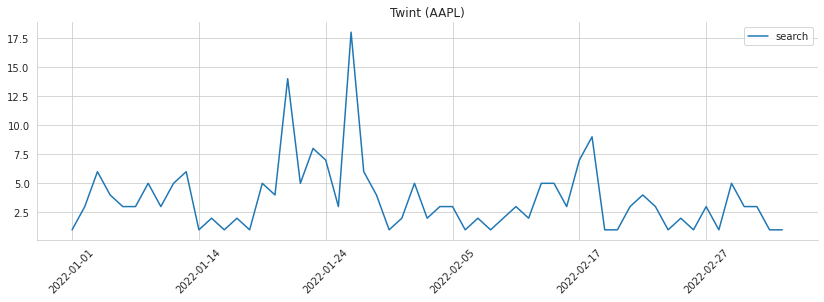

In [275]:
ax = df_aapl_groupedby_date["search"].plot(title='Twint (AAPL)',
           legend=True,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
sns.despine()

In [276]:
df.head()

,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
id,,,,,,,,,,,,,,,,,,,,,
1477328608741974018,1477328608741974018,1.641058e+12,2022-01-01,+0000,,Chip Stocks Are Booming. Where to Find Bargains Now $MU $QRVO $AMKR $SWKS $QCOM $INTC $MCHP $LRCX $AMAT $KLAC $ON $AVGO $NXPI $MCHP $IIVI https://t.co/YLvxmVAFM2 https://t.co/RdCEiV1H4k,en,[],"[mu, qrvo, amkr, swks, qcom, intc, mchp, lrcx, amat, klac, on, avgo, nxpi, mchp, iivi]",475524030,...,,,,,,[],,,,
1477715599648301057,1477715599648301057,1.641150e+12,2022-01-02,+0000,,HIGH CONFIDENCE WATCHLIST FOR 01/03/21: - $INTC Calls above 52.15 Puts under 51.47 - $AAPL Calls above 178.58 Puts under 177.27 - $NIO Calls above 31.88 Puts under 30.23 - $DIS Calls above 155.97 Puts under 154.61 50❤️'s FOR A BONUS PLAY/CHART TONIGHT! (FLOW @unusual_whales) https://t.co/velxEMPuuX,en,[],"[intc, aapl, nio, dis]",1432422507886284800,...,,,,,,[],,,,
1477698839691804683,1477698839691804683,1.641146e+12,2022-01-02,+0000,,FREE #OPTIONS Ideas 🤯 Scale out when above 25% Profit $NIO 33C&gt;32.85 | 31P&lt;31.79 $TSLA 1080C&gt;1079.26 | 1050P&lt;1057.33 $INTC 53C&gt;52.09 | 51P&lt;51.53 $PLTR 19C&gt;18.85 | 18P&lt;18.28 199 ❤️for TOP SECRET Bonus Picks Comment if you like the Old Chart Format or the NEW VIDEO FORMAT! https://t.co/xjsAXxs06L,en,[options],"[nio, tsla, intc, pltr]",1254439066386477056,...,,,,,,[],,,,
1477658620896677895,1477658620896677895,1.641136e+12,2022-01-02,+0000,,"""It almost doesn’t matter what you know... It’s execution that’s everything.” Andy Grove, former CEO- $INTC",en,[],[intc],47087332,...,,,,,,[],,,,
1478436063588802566,1478436063588802566,1.641322e+12,2022-01-04,+0000,,Acer Inc. is releasing new gaming laptops featuring the newest $NVDA and $INTC CPUs and GPUs,en,[],"[nvda, intc]",817007725666242561,...,,,,,,[],,,,


In [277]:
ticker_cleaned = ticker[idx].replace("$", "")
path = pathlib.Path.cwd() / f'{ticker_cleaned}_twint_{year}.csv'

df.to_csv(path)

In [278]:
print(path)

/app/StockPricePredictions/src/exploratory_data_analysis/chance/python/samples/twint/INTC_twint_2022.csv


In [279]:
df_x = pd.read_csv(path, lineterminator='\n')

In [280]:
df_x.shape

(209, 38)